In [42]:
import pandas as pd
import tensorflow as tf
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from tensorflow.python.keras.preprocessing.text import Tokenizer 
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping
from attention import AttentionLayer
from itertools import chain

In [17]:
df = pd.read_csv('arts.csv')

In [18]:
#Data cleaning
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True)

In [19]:
df.shape #15 data points were deleted during data formatting process

(1882, 5)

In [20]:
#data preprocessing
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [45]:
#All credits to preprocessing stage goes to https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def text_cleaner(text):
    newString = text.lower() #lower case
    newString = BeautifulSoup(newString, "html.parser").text #remove html tags
    newString = re.sub(r'\([^)]*\)', '', newString) 
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in df['text']:
    cleaned_text.append(text_cleaner(t))

In [46]:
def headline_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString


cleaned_headline = []
for t in df['title']:
    cleaned_headline.append(headline_cleaner(t))

In [47]:
df['cleaned text'] = cleaned_text
df['cleaned headline'] = cleaned_headline
df['cleaned headline'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)
df['cleaned headline'] = df['cleaned headline'].apply(lambda x : '_START_ '+ x + ' _END_')

In [24]:
df.head()

,link,title,date,author,text,cleaned text,cleaned headline
0,https://www.nytimes.com/2018/12/05/books/the-w...,The Way We Read \n,2018-12-05\n,Erica Ackerberg\n,Donald and Patricia Oresman's New York City ho...,donald patricia oresman new york city home des...,_START_ the way we read _END_
1,https://www.nytimes.com/2018/12/07/books/revie...,Colm Toibin on the Fathers of Geniuses \n,2018-12-07\n,Gregory Cowles\n,"MAD, BAD, DANGEROUS TO KNOW The Fathers of Wil...",mad bad dangerous know fathers wilde yeats joy...,_START_ colm toibin on the fathers of geniuses...
2,https://www.nytimes.com/2018/12/21/world/afric...,"Guitarist Has Brain Surgery, and Strums All th...",2018-12-21\n,Kimon de Greef\n,CAPE TOWN - A musician from South Africa had a...,cape town musician south africa tumor brain do...,_START_ guitarist has brain surgery and strums...
3,https://www.nytimes.com/2019/01/17/movies/film...,4 Film Series to Catch in N.Y.C. This Weekend \n,2019-01-17\n,Ben Kenigsberg\n,Our guide to film series and special screening...,guide film series special screenings happening...,_START_ film series to catch in this weekend ...
4,https://www.nytimes.com/2018/12/03/arts/music/...,"Review: Exploring Langston Hughes in Song, Loc...",2018-12-03\n,Zachary Woolfe\n,"On the morning of July 16, 1964, James Powell,...",morning july james powell year old black stude...,_START_ review exploring langston hughes in so...


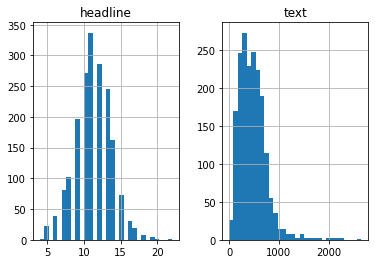

In [48]:
#data analysis
#compute text length
text_word_counts = []
headline_word_counts = []
for i in df['cleaned text']:
    text_word_counts.append(len(i.split()))
    
for i in df['cleaned headline']:
    headline_word_counts.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_counts, 'headline':headline_word_counts})
length_df.hist(bins = 30)
plt.show()

In [49]:
max_headline_length = 22
max_text_length = 1500  #a majority of texts are below 1500 with several outliers, so we set max text length to 1200


In [56]:
x_train, x_test, y_train, y_test = train_test_split(list(df['cleaned text']), list(df['cleaned headline']), random_state = 0, shuffle = True)

['religion personal story elaine pagels ecco harpercollins publisher everyone mourns differently template grief religion offer framework structure ritual prayer elaine pagels professor religion princeton university make abundantly clear new memoir substitute inner work death loved one force pagels come knowledge honestly lost first child born hole heart soon thereafter year old husband slipped fell death hiking leaving two child age recounting personal story long time coming husband child died year ago reading life love work unimaginable pain feel difficult reserved scholar early christianity enter black hole feeling account none frenzied claustrophobic madness joan didion year magical thinking wild pain rushing love sonali deraniyagala wave written aftermath sudden death family tsunami story woman refuge academia pursuit wisdom ultimately offered needed heal broken heart fueled intellect fortunate access gnostic gospel first century second century christian text unearthed egyptian ara

In [51]:
#text tokenization. Credits go to https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
#word2vec, bag of words, glove or word embeddings?
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))


x_train =  x_tokenizer.texts_to_sequences(x_train) 
x_test = x_tokenizer.texts_to_sequences(x_test)


x_train = pad_sequences(x_train,  maxlen=max_text_length, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_text_length, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1


In [30]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train =  y_tokenizer.texts_to_sequences(y_train) 
y_test =  y_tokenizer.texts_to_sequences(y_test) 

y_train =  pad_sequences(y_train, maxlen=max_headline_length, padding='post')
y_test =  pad_sequences(y_test, maxlen=max_headline_length, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [38]:
from tensorflow.python.keras import backend as K 
K.clear_session() 
latent_dim = 250 

# Encoder 
encoder_inputs = Input(shape=(max_text_length,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)


# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

print ("encoder outputs shape: ", encoder_outputs.shape)
print ("decoder outputs shape: ", decoder_outputs.shape)

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

encoder outputs shape:  (None, 1500, 250)
decoder outputs shape:  (None, None, 250)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 250)    12131750    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 250)    1005500     input_2[0][0]                    
__________

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [53]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [33]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))


Epoch 1/50


KeyboardInterrupt: 

In [30]:
import numpy as np
from itertools import chain

def _indexing(x, indices):
    """
    :param x: array from which indices has to be fetched
    :param indices: indices to be fetched
    :return: sub-array from given array and indices
    """
    # np array indexing
    if hasattr(x, 'shape'):
        return x[indices]

    # list indexing
    return [x[idx] for idx in indices]

def train_test_split(*arrays, test_size=0.25, shuffle=True, random_seed=1):
    """
    splits array into train and test data.
    :param arrays: arrays to split in train and test
    :param test_size: size of test set in range (0,1)
    :param shufffle: whether to shuffle arrays or not
    :param random_seed: random seed value
    :return: return 2*len(arrays) divided into train ans test
    """
    # checks
    assert 0 < test_size < 1
    assert len(arrays) > 0
    length = len(arrays[0])
    for i in arrays:
        assert len(i) == length

    n_test = int(np.ceil(length*test_size))
    n_train = length - n_test

    if shuffle:
        perm = np.random.RandomState(random_seed).permutation(length)
        test_indices = perm[:n_test]
        train_indices = perm[n_test:]
    else:
        train_indices = np.arange(n_train)
        test_indices = np.arange(n_train, length)

    return list(chain.from_iterable((_indexing(x, train_indices), _indexing(x, test_indices)) for x in arrays))